In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from scipy.stats import shapiro, kstest



pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [2]:
df = pd.read_csv('hr_raw_data_v2.csv')

In [3]:
df.head()

,employee_number,gender,birth_year,age,marital_status,dist_home,job_title,department,departured,year_at_comp,standard_hours,remote,business_travel,over_time,job_level,stock_opt_level,traning_times_last_year,perf_rate,year_last_promotion,year_current_mngr,education_field,education_scale,annual_salary,monthly_income,daily_rate,perc_salary_hike,env_sat_rate,job_involvement,job_sat_rate,relationship_sat_rate,work_life_balance,num_comp_worked,tot_working_year
0,1,M,1972,51.0,Unknown,6,Research Director,Research & Development,No,20,Full Time,Yes,Unknown,No,5,0,5,3.0,15,15,Unknown,3,195370.00,16280.830000,2015.722222,13,1,3,3,3,3.0,7,NaN
1,2,M,1971,52.0,Unknown,1,Manager,Unknown,No,33,NaN,Yes,Unknown,Unknown,5,1,5,3.0,11,9,Life Sciences,4,199990.00,16125.406667,2063.388889,14,3,2,3,1,3.0,0,34.0
2,3,M,1981,42.0,Married,4,Manager,Research & Development,No,22,NaN,Yes,travel_rarely,No,5,0,3,3.0,11,15,Technical Degree,2,192320.00,15943.720000,1984.253968,11,3,3,4,4,NaN,1,22.0
3,4,F,1976,47.0,Married,2,Research Director,Research & Development,No,20,Full Time,No,travel_rarely,Unknown,4,2,2,3.0,5,6,Medical,4,171690.00,14307.500000,1771.404762,19,1,3,3,2,NaN,3,NaN
4,5,F,1977,46.0,Divorced,3,Sales Executive,Sales,No,19,NaN,No,Unknown,No,4,1,5,3.0,2,8,Technical Degree,3,153407.07,12783.920000,1582.771346,12,1,4,1,4,3.0,2,NaN


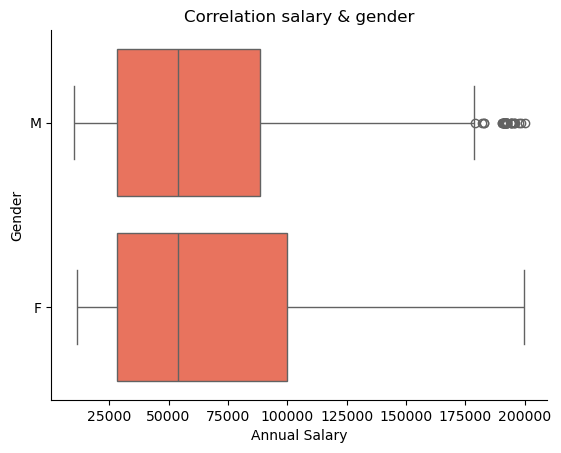

In [27]:
sns.boxplot(data=df, y='gender', x='annual_salary', color = 'tomato')
plt.title('Correlation salary & gender')
plt.xlabel('Annual Salary')
plt.ylabel('Gender')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

In [5]:
df['standard_hours'].mode()

0    Part Time
Name: standard_hours, dtype: object

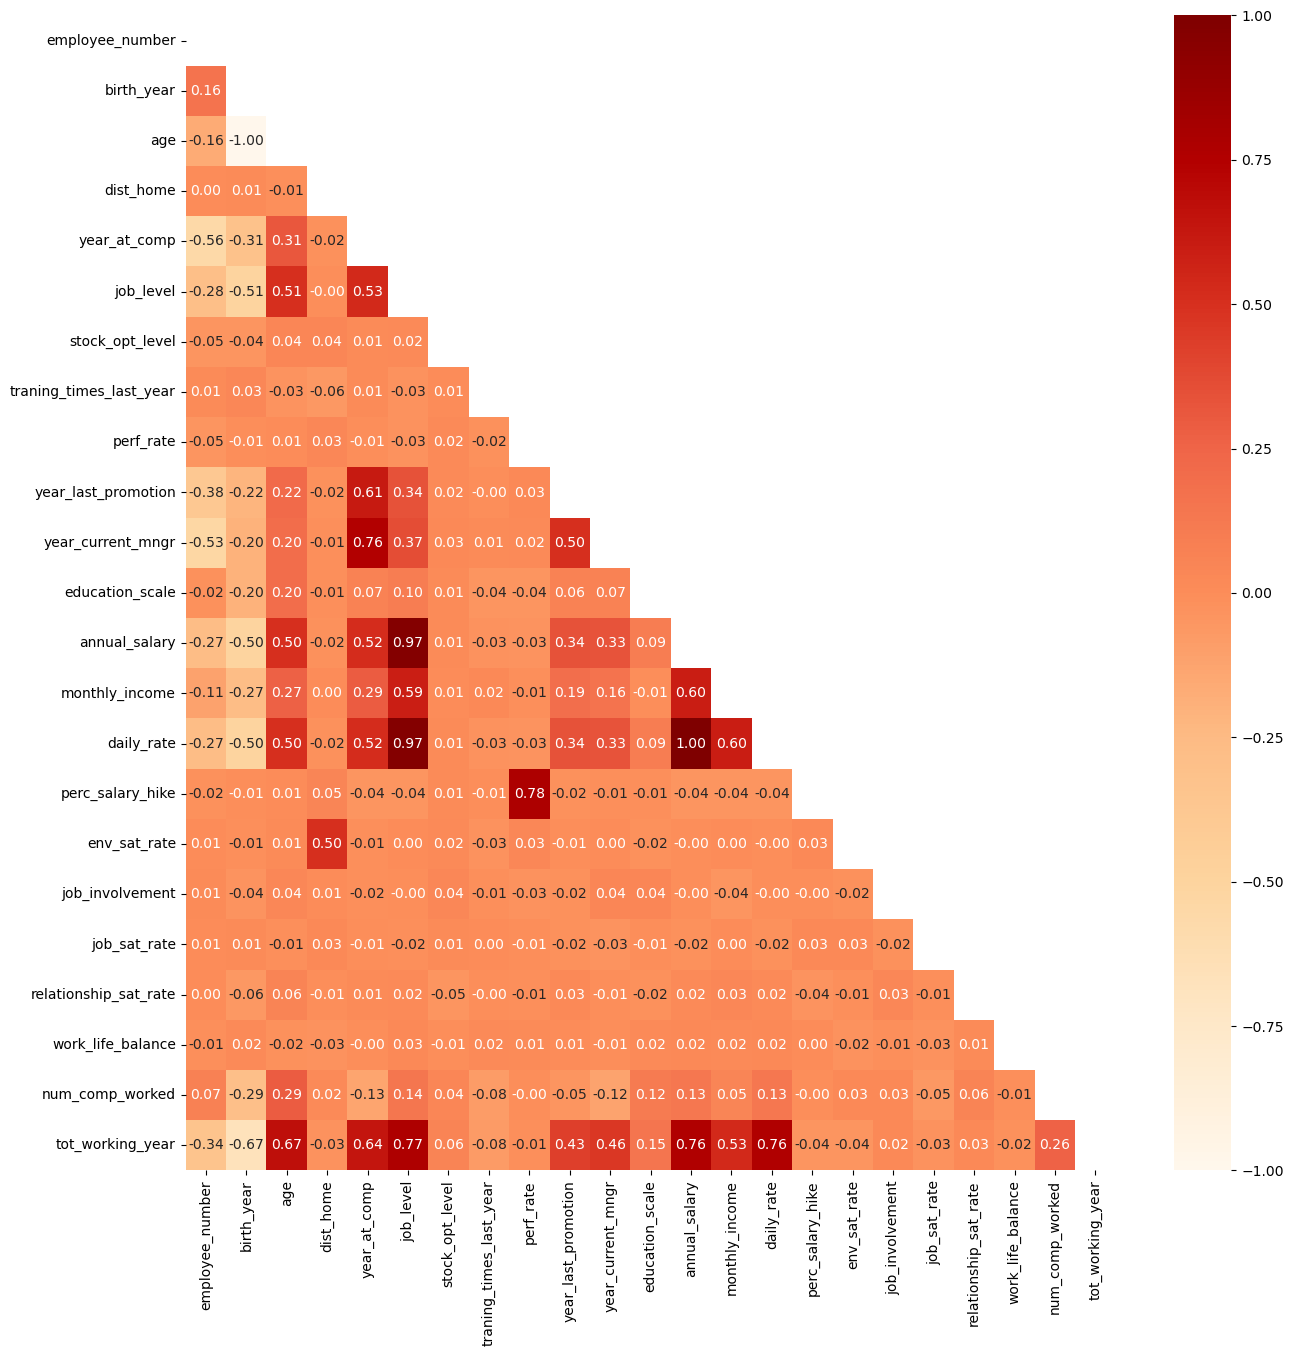

In [6]:
# GENERAL DATA ANALYSIS

numerics = df.select_dtypes(exclude = 'O').columns
df_corr = df[numerics].corr(method = 'pearson')


plt.figure(figsize = (15, 15))

mask = np.triu(np.ones_like(df_corr, dtype=bool))

sns.heatmap(df_corr, 
            annot = True, 
            fmt = ".2f", 
            cmap = "OrRd", 
            vmax = 1, 
            vmin = -1, 
            mask = mask); 

In [7]:
df.isnull().sum() / df.shape[0] * 100

employee_number             0.000000
gender                      0.000000
birth_year                  0.000000
age                         0.000000
marital_status              0.000000
dist_home                   0.000000
job_title                   0.000000
department                  0.000000
departured                  0.000000
year_at_comp                0.000000
standard_hours             20.941760
remote                      0.000000
business_travel             0.000000
over_time                   0.000000
job_level                   0.000000
stock_opt_level             0.000000
traning_times_last_year     0.000000
perf_rate                  12.081784
year_last_promotion         0.000000
year_current_mngr           0.000000
education_field             0.000000
education_scale             0.000000
annual_salary               0.000000
monthly_income              0.000000
daily_rate                  0.000000
perc_salary_hike            0.000000
env_sat_rate                0.000000
j

In [8]:
df_estadisticos_cat = df.select_dtypes(include = 'O').describe().T

In [9]:
df_estadisticos_cat['freq%'] = df_estadisticos_cat['freq'].values/df.shape[0]*100

In [10]:
df_estadisticos_cat

,count,unique,top,freq,freq%
gender,1614,2,M,971,60.16109
marital_status,1614,4,Unknown,651,40.334572
job_title,1614,9,Sales Executive,369,22.862454
department,1614,4,Research & Development,1001,62.019827
departured,1614,2,No,1355,83.952912
standard_hours,1276,2,Part Time,888,55.018587
remote,1614,2,Yes,1000,61.957869
business_travel,1614,4,Unknown,772,47.831475
over_time,1614,3,No,682,42.255266
education_field,1614,7,Unknown,745,46.158612


In [11]:
df['salary_scale'] = pd.cut(df['annual_salary'],bins = 3, labels= ['Low', 'Medium', 'High']) 

In [12]:
# filtramos los datos para obtener los grupos. Estos grupos van a ser series de datos
grupo_research = df[df['department'] == 'Research & Development'] [['annual_salary','standard_hours', 'salary_scale']]
grupo_unknown = df[df['department'] == 'Unknown'] [['annual_salary','standard_hours', 'salary_scale']]
grupo_sales = df[df['department'] == 'Sales'] [['annual_salary','standard_hours', 'salary_scale']]
grupo_hhrr = df[df['department'] == 'Human Resources'] [['annual_salary','standard_hours', 'salary_scale']]

In [13]:
lista = ['Research & Development', 'Unknown', 'Sales', 'Human Resources']

In [14]:
lista1 = ['Part Time', 'Full Time']

In [15]:
df_grupo_research = pd.DataFrame(grupo_research)
df_grupo_unknown = pd.DataFrame(grupo_unknown)
df_grupo_sales = pd.DataFrame(grupo_sales)
df_grupo_hhrr = pd.DataFrame(grupo_hhrr)

In [16]:
#imprimimos las estadísticas:
for filtro in lista:
    print(filtro)
    display(df[df['department'] == filtro]['annual_salary'].describe().round(2).reset_index().T)
    print('-' * 40)

Research & Development


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
annual_salary,1001.0,58414.13,43038.75,10090.0,28111.13,44220.0,64720.0,199730.0


----------------------------------------
Unknown


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
annual_salary,91.0,167680.14,27964.12,100071.84,153407.07,170990.0,191324.62,199990.0


----------------------------------------
Sales


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
annual_salary,464.0,61231.4,28763.74,10520.0,48387.5,53914.11,69690.0,187890.0


----------------------------------------
Human Resources


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
annual_salary,58.0,45159.34,27708.86,20640.0,28111.13,28111.13,53914.11,153407.07


----------------------------------------


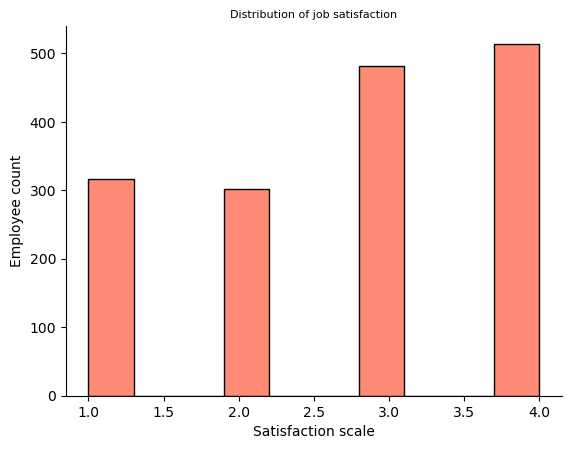

In [30]:
sns.histplot(data=df, x='job_sat_rate', bins=10, kde=False, color='tomato')
plt.title('Distribution of job satisfaction', fontsize = 8)
plt.xlabel('Satisfaction scale')
plt.ylabel('Employee count')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

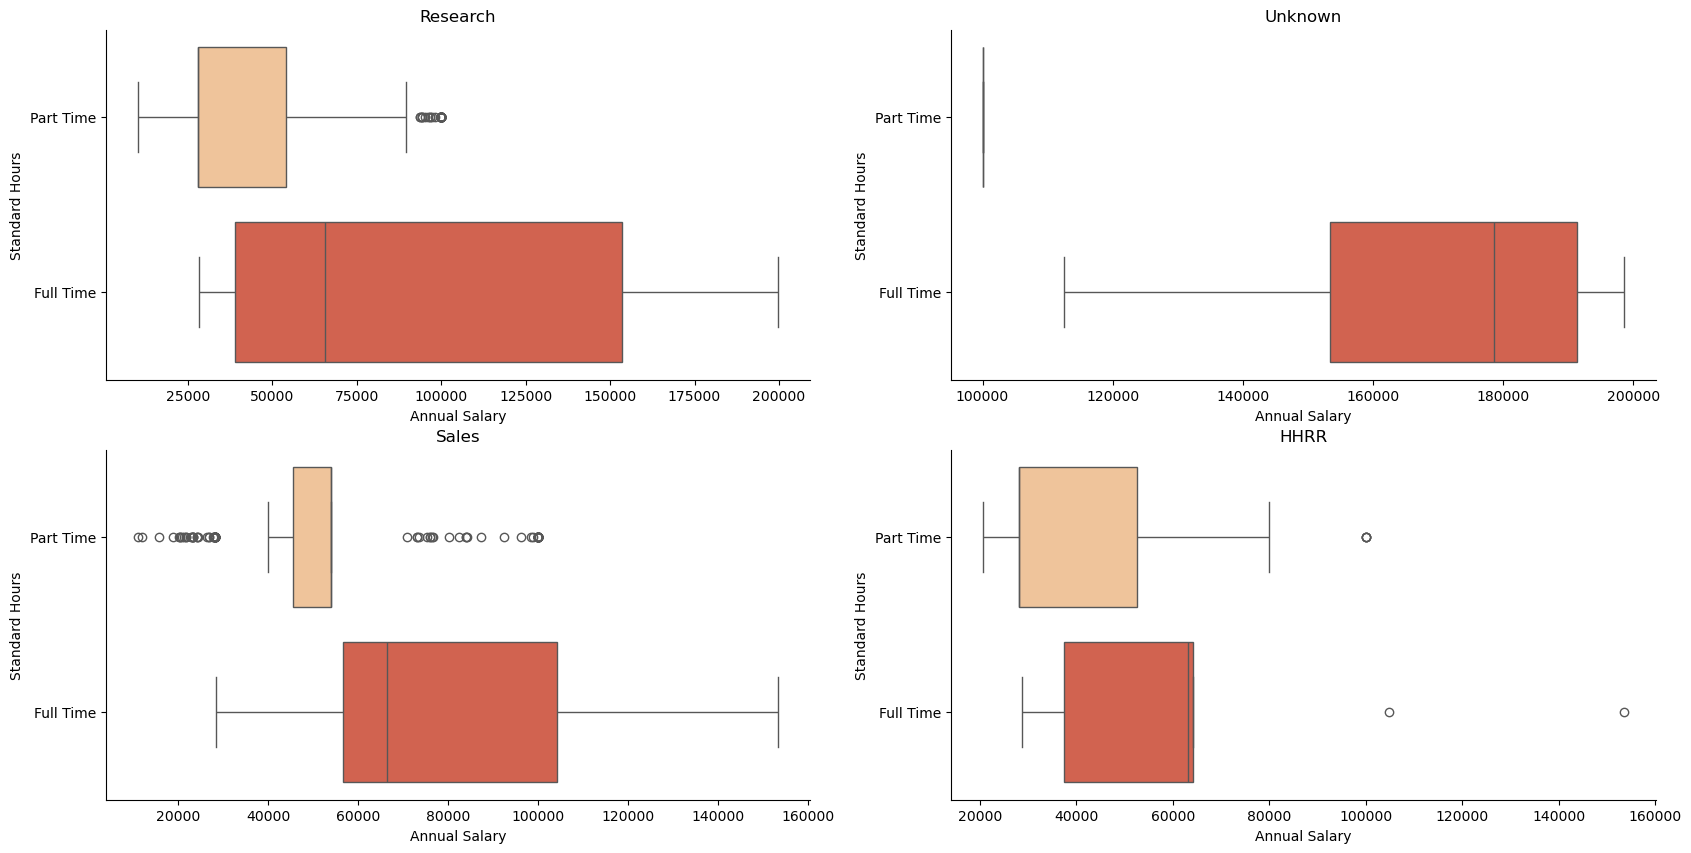

In [17]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))
sns.boxplot(x = "annual_salary",
            y = "standard_hours",
            order = lista1,
            data = df_grupo_research,
            palette = "OrRd",
            ax = axes[0,0])
axes[0,0].set_title("Research")
axes[0,0].set_xlabel("Annual Salary")
axes[0,0].set_ylabel("Standard Hours")
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['top'].set_visible(False)

sns.boxplot(x = "annual_salary",
            y = "standard_hours",
            order = lista1,
            data = df_grupo_unknown,
            palette = "OrRd",
            ax = axes[0,1])
axes[0,1].set_title("Unknown")
axes[0,1].set_xlabel("Annual Salary")
axes[0,1].set_ylabel("Standard Hours")
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['top'].set_visible(False)

sns.boxplot(x = "annual_salary",
            y = "standard_hours",
            order = lista1,
            data = df_grupo_sales,
            palette = "OrRd",
            ax = axes[1,0])
axes[1,0].set_title("Sales")
axes[1,0].set_xlabel("Annual Salary")
axes[1,0].set_ylabel("Standard Hours")
axes[1,0].spines['right'].set_visible(False)
axes[1,0].spines['top'].set_visible(False)

sns.boxplot(x = "annual_salary",
            y = "standard_hours",
            order = lista1,
            data = df_grupo_hhrr,
            palette = "OrRd",
            ax = axes[1,1])
axes[1,1].set_title("HHRR")
axes[1,1].set_xlabel("Annual Salary")
axes[1,1].set_ylabel("Standard Hours")
axes[1,1].spines['right'].set_visible(False)
axes[1,1].spines['top'].set_visible(False);

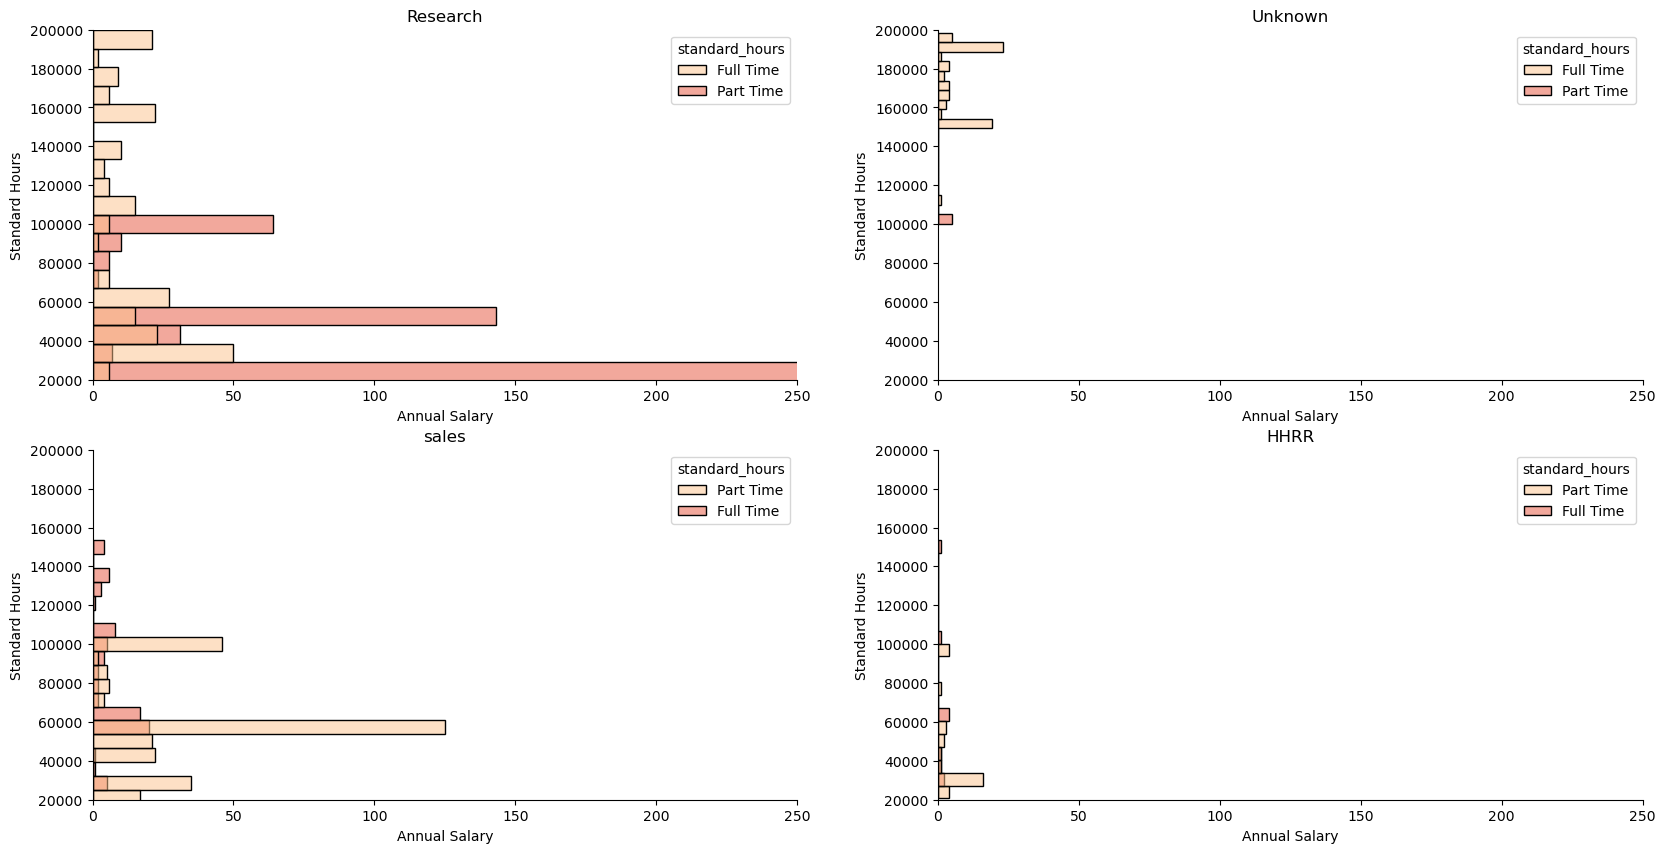

In [18]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

sns.histplot(y = "annual_salary",
            hue = "standard_hours", 
            data = df_grupo_research, 
            palette = "OrRd", 
            bins = 20, 
            ax = axes[0,0])
axes[0,0].set_title("Research")
axes[0,0].set_xlabel("Annual Salary")
axes[0,0].set_ylabel("Standard Hours")
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['top'].set_visible(False)

sns.histplot(y = "annual_salary",
            hue = "standard_hours",  
            data = df_grupo_unknown, 
            palette = "OrRd", 
            bins = 20, 
            ax = axes[0,1])
axes[0,1].set_title("Unknown")
axes[0,1].set_xlabel("Annual Salary")
axes[0,1].set_ylabel("Standard Hours")
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['top'].set_visible(False)

sns.histplot(y = "annual_salary",
            hue = "standard_hours",  
            data = df_grupo_sales, 
            palette = "OrRd", 
            bins = 20, 
            ax = axes[1,0])
axes[1,0].set_title("sales")
axes[1,0].set_xlabel("Annual Salary")
axes[1,0].set_ylabel("Standard Hours")
axes[1,0].spines['right'].set_visible(False)
axes[1,0].spines['top'].set_visible(False)

sns.histplot(y = "annual_salary",
            hue = "standard_hours",  
            data = df_grupo_hhrr, 
            palette = "OrRd", 
            bins = 20, 
            ax = axes[1,1])
axes[1,1].set_title("HHRR")
axes[1,1].set_xlabel("Annual Salary")
axes[1,1].set_ylabel("Standard Hours")
axes[1,1].spines['right'].set_visible(False)
axes[1,1].spines['top'].set_visible(False)

#ponemos la misma escala en los ejes:
#eje x, para asegurarnos que coge bien el mes núm 12:
axes[0,0].set_xlim(0,250) 
axes[0,1].set_xlim(0,250) 
axes[1,0].set_xlim(0,250) 
axes[1,1].set_xlim(0,250) 

#eje y, hasta 120.000:
axes[0,0].set_ylim(20000,200000) 
axes[0,1].set_ylim(20000,200000) 
axes[1,0].set_ylim(20000,200000) 
axes[1,1].set_ylim(20000,200000);

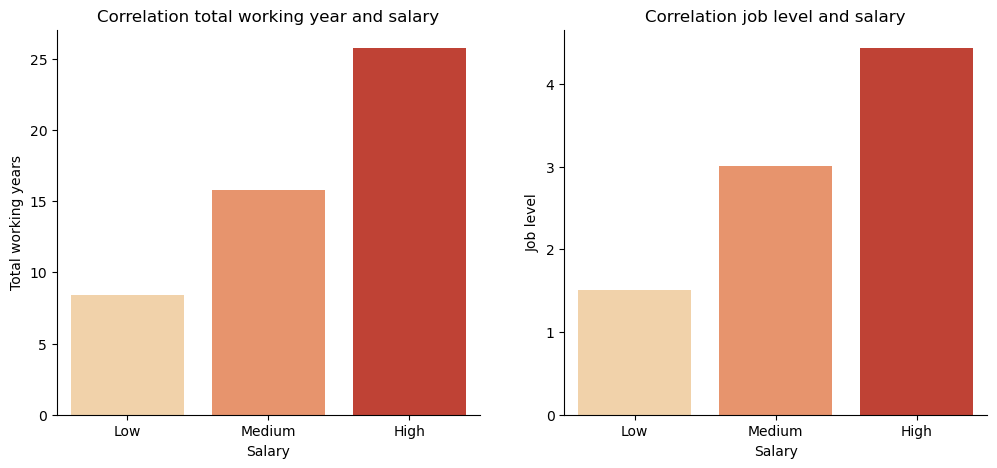

In [19]:
df['salary_scale'] = pd.cut(df['annual_salary'],bins = 3, labels= ['Low', 'Medium', 'High']) 

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

sns.barplot(data=df, y='tot_working_year', 
            x='salary_scale',
            palette='OrRd',
            ci=False,
            ax=axes[0])
axes[0].set_title("Correlation total working year and salary")
axes[0].set_xlabel("Salary")
axes[0].set_ylabel("Total working years")
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

sns.barplot(data=df, y='job_level', 
            x='salary_scale',
            palette='OrRd',
            ci=False)
axes[1].set_title("Correlation job level and salary")
axes[1].set_ylabel("Job level")
axes[1].set_xlabel("Salary")
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
plt.show();


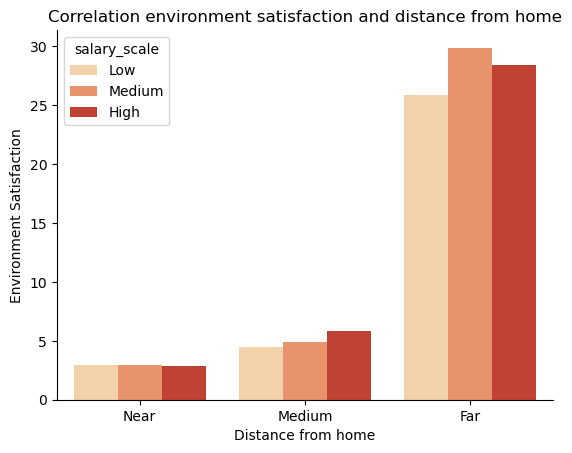

In [20]:
df['dist_home_scale'] = pd.cut(df['dist_home'],bins = 3, labels= ['Near', 'Medium', 'Far']) 


sns.barplot(data=df, y='env_sat_rate', 
            x='dist_home_scale',
            palette= 'OrRd',
            hue= 'salary_scale',
            ci=False)

plt.title("Correlation environment satisfaction and distance from home")
plt.ylabel("Environment Satisfaction")
plt.xlabel("Distance from home")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);


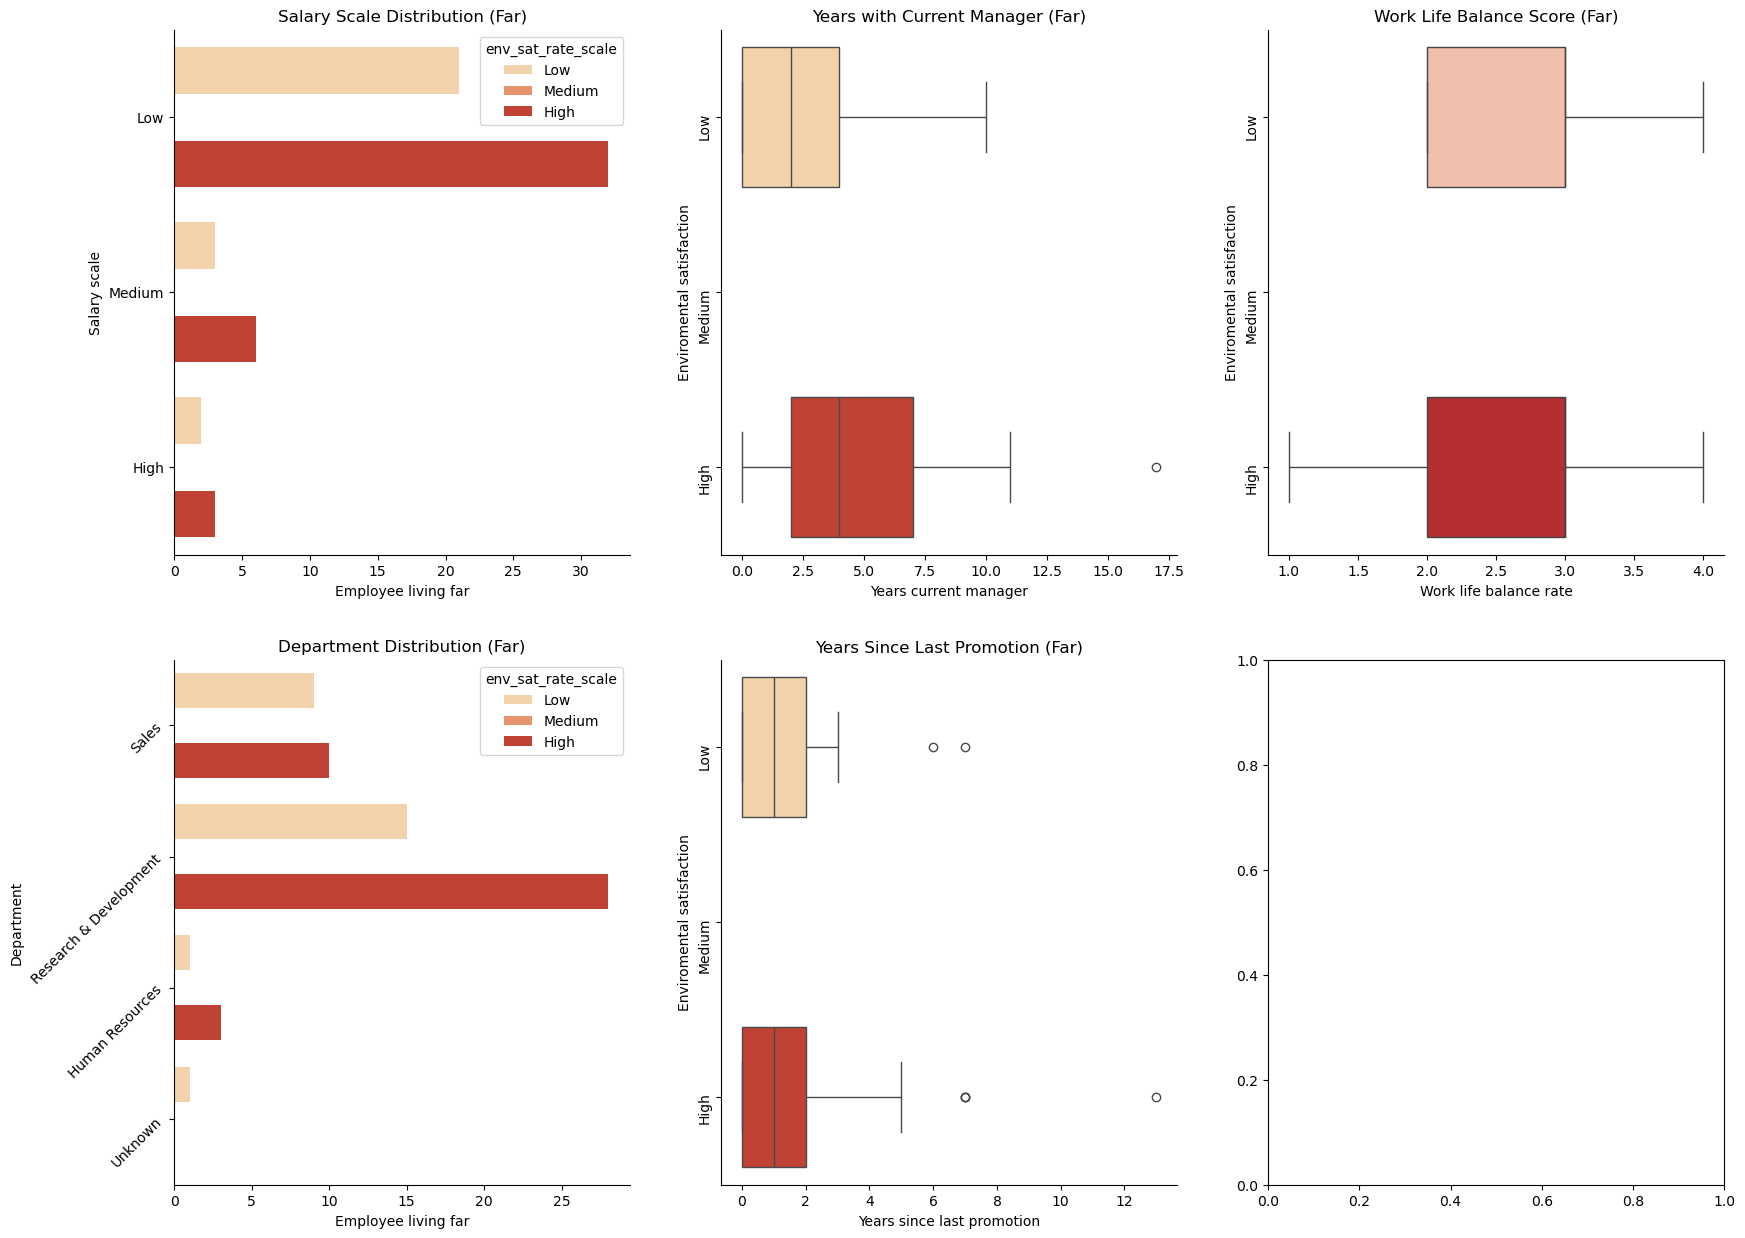

In [21]:
df['env_sat_rate_scale'] = pd.cut(df['env_sat_rate'],bins = 3, labels= ['Low', 'Medium', 'High'])
far_df = df[df['dist_home_scale'] == 'Far']
fig, axes = plt.subplots(2, 3, figsize=(20, 15)) 

sns.countplot(data=far_df,
              y='salary_scale',
              hue='env_sat_rate_scale',
              ax=axes[0,0],
              palette='OrRd')
axes[0,0].set_title('Salary Scale Distribution (Far)')
axes[0,0].set_xlabel('Employee living far')
axes[0,0].set_ylabel('Salary scale')
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['top'].set_visible(False)


sns.countplot(data=far_df,
              y='department',
              hue='env_sat_rate_scale',
              ax=axes[1,0],
              palette='OrRd')
axes[1,0].set_title('Department Distribution (Far)')
axes[1,0].tick_params(axis='y', rotation=45)
axes[1,0].set_xlabel('Employee living far')
axes[1,0].set_ylabel('Department')
axes[1,0].spines['right'].set_visible(False)
axes[1,0].spines['top'].set_visible(False)


sns.boxplot(data=far_df,
            x='year_current_mngr',
            ax=axes[0,1],
            y='env_sat_rate_scale',
            palette='OrRd')
axes[0,1].set_title('Years with Current Manager (Far)')
axes[0,1].tick_params(axis='y', rotation=45)
axes[0,1].set_xlabel('Years current manager')
axes[0,1].set_ylabel('Enviromental satisfaction')
axes[0,1].tick_params(axis='y', rotation=90)
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['top'].set_visible(False)


sns.boxplot(data=far_df, x='year_last_promotion',
            y='env_sat_rate_scale',
            ax=axes[1,1],
            palette='OrRd')
axes[1,1].set_title('Years Since Last Promotion (Far)')
axes[1,1].tick_params(axis='y', rotation=90)
axes[1,1].set_ylabel('Enviromental satisfaction')
axes[1,1].set_xlabel('Years since last promotion')
axes[1,1].spines['right'].set_visible(False)
axes[1,1].spines['top'].set_visible(False)


sns.boxplot(data=far_df, x='work_life_balance',
            y='env_sat_rate_scale',
            ax=axes[0,2],
            palette='Reds')
axes[0,2].set_title('Work Life Balance Score (Far)')
axes[0,2].set_ylabel('Enviromental satisfaction')
axes[0,2].tick_params(axis='y', rotation=90)
axes[0,2].set_xlabel('Work life balance rate')
axes[0,2].spines['right'].set_visible(False)
axes[0,2].spines['top'].set_visible(False)
plt.show();

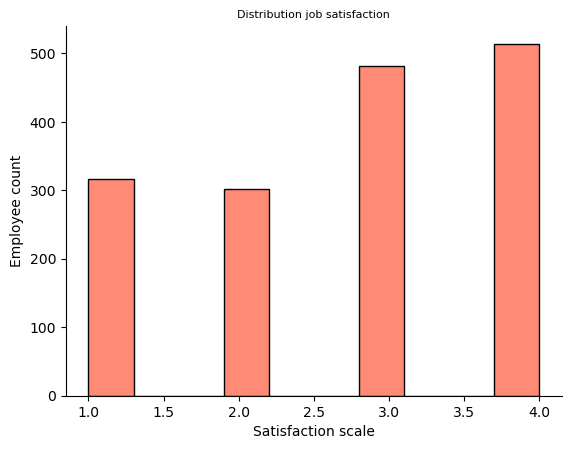

In [33]:
sns.histplot(data=df, x='job_sat_rate', bins=10, kde=False, color='tomato')
plt.title('Distribution job satisfaction', fontsize = 8)
plt.xlabel('Satisfaction scale')
plt.ylabel('Employee count');
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

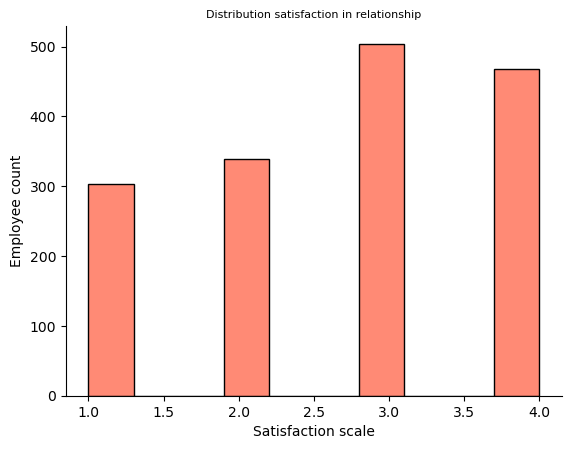

In [36]:
sns.histplot(data=df, x='relationship_sat_rate', bins=10, kde=False, color='tomato')
plt.title('Distribution satisfaction in relationship', fontsize = 8)
plt.xlabel('Satisfaction scale')
plt.ylabel('Employee count')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

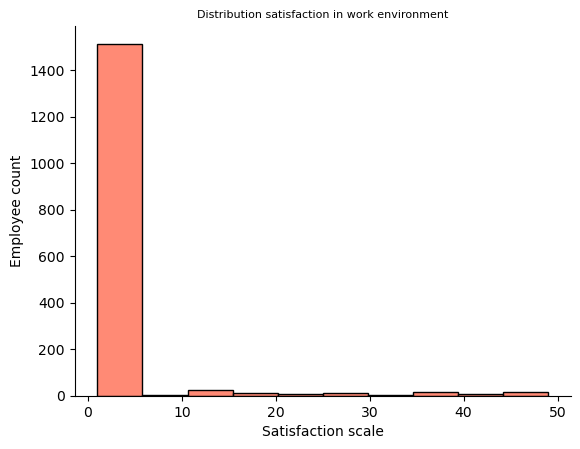

In [37]:
sns.histplot(data=df, x='env_sat_rate', bins=10, kde=False, color='tomato')
plt.title('Distribution satisfaction in work environment', fontsize = 8)
plt.xlabel('Satisfaction scale')
plt.ylabel('Employee count')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

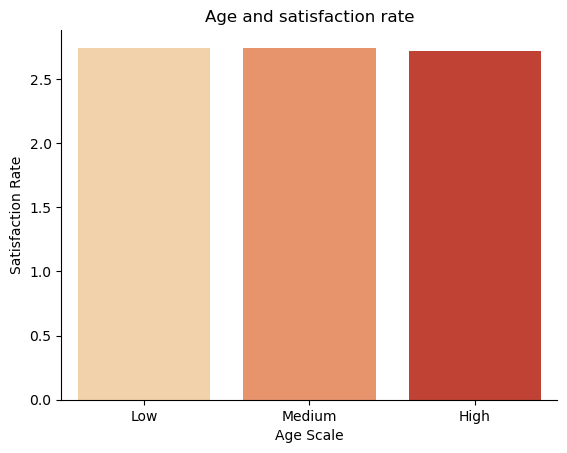

In [38]:
df['age_scale'] = pd.cut(df['age'],bins = 3, labels= ['Low', 'Medium', 'High'])
sns.barplot(data=df, y='job_sat_rate',
            x='age_scale',
            palette= 'OrRd',
            ci=False)
plt.title("Age and satisfaction rate")
plt.ylabel("Satisfaction Rate")
plt.xlabel("Age Scale")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

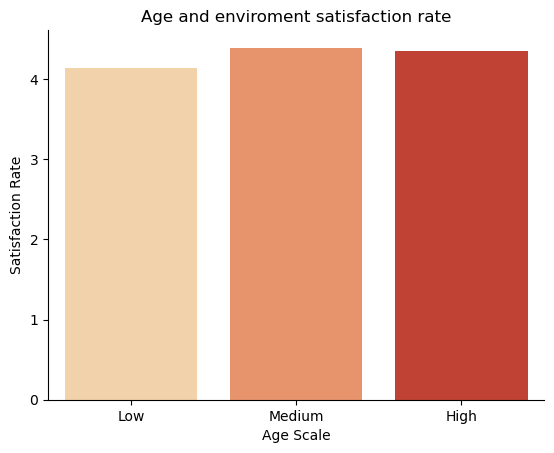

In [39]:
df['age_scale'] = pd.cut(df['age'],bins = 3, labels= ['Low', 'Medium', 'High'])
sns.barplot(data=df, y='env_sat_rate',
            x='age_scale',
            palette= 'OrRd',
            ci=False)
plt.title("Age and enviroment satisfaction rate")
plt.ylabel("Satisfaction Rate")
plt.xlabel("Age Scale")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

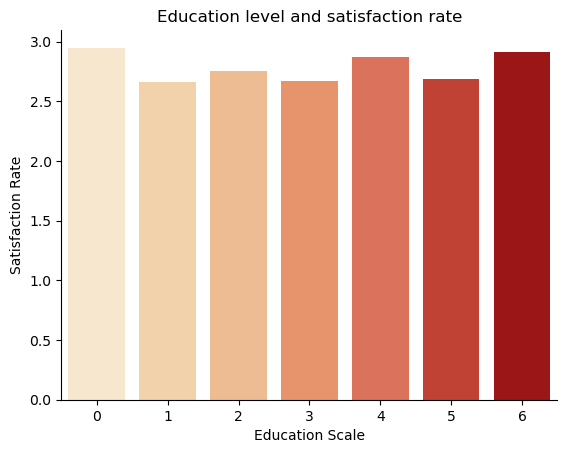

In [41]:
df['age_scale'] = pd.cut(df['age'],bins = 3, labels= ['Low', 'Medium', 'High'])
sns.barplot(data=df, y='job_sat_rate',
            x='traning_times_last_year',
            palette= 'OrRd',
            ci=False)
plt.title("Education level and satisfaction rate")
plt.ylabel("Satisfaction Rate")
plt.xlabel("Education Scale")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

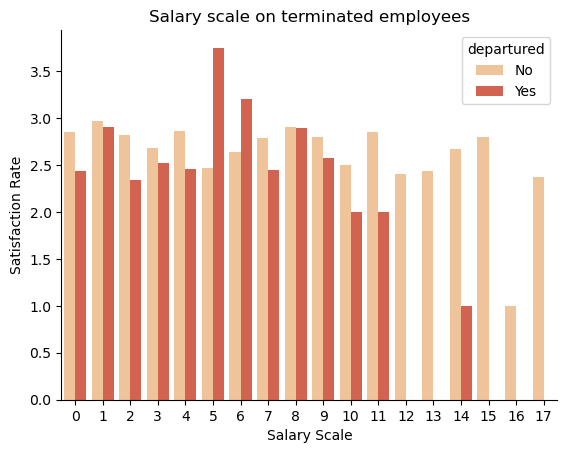

In [42]:
sns.barplot(data=df, y='job_sat_rate',
            x='year_current_mngr',
            hue='departured',
            palette= 'OrRd',
            ci=False)
plt.title("Salary scale on terminated employees")
plt.ylabel("Satisfaction Rate")
plt.xlabel("Salary Scale")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False);

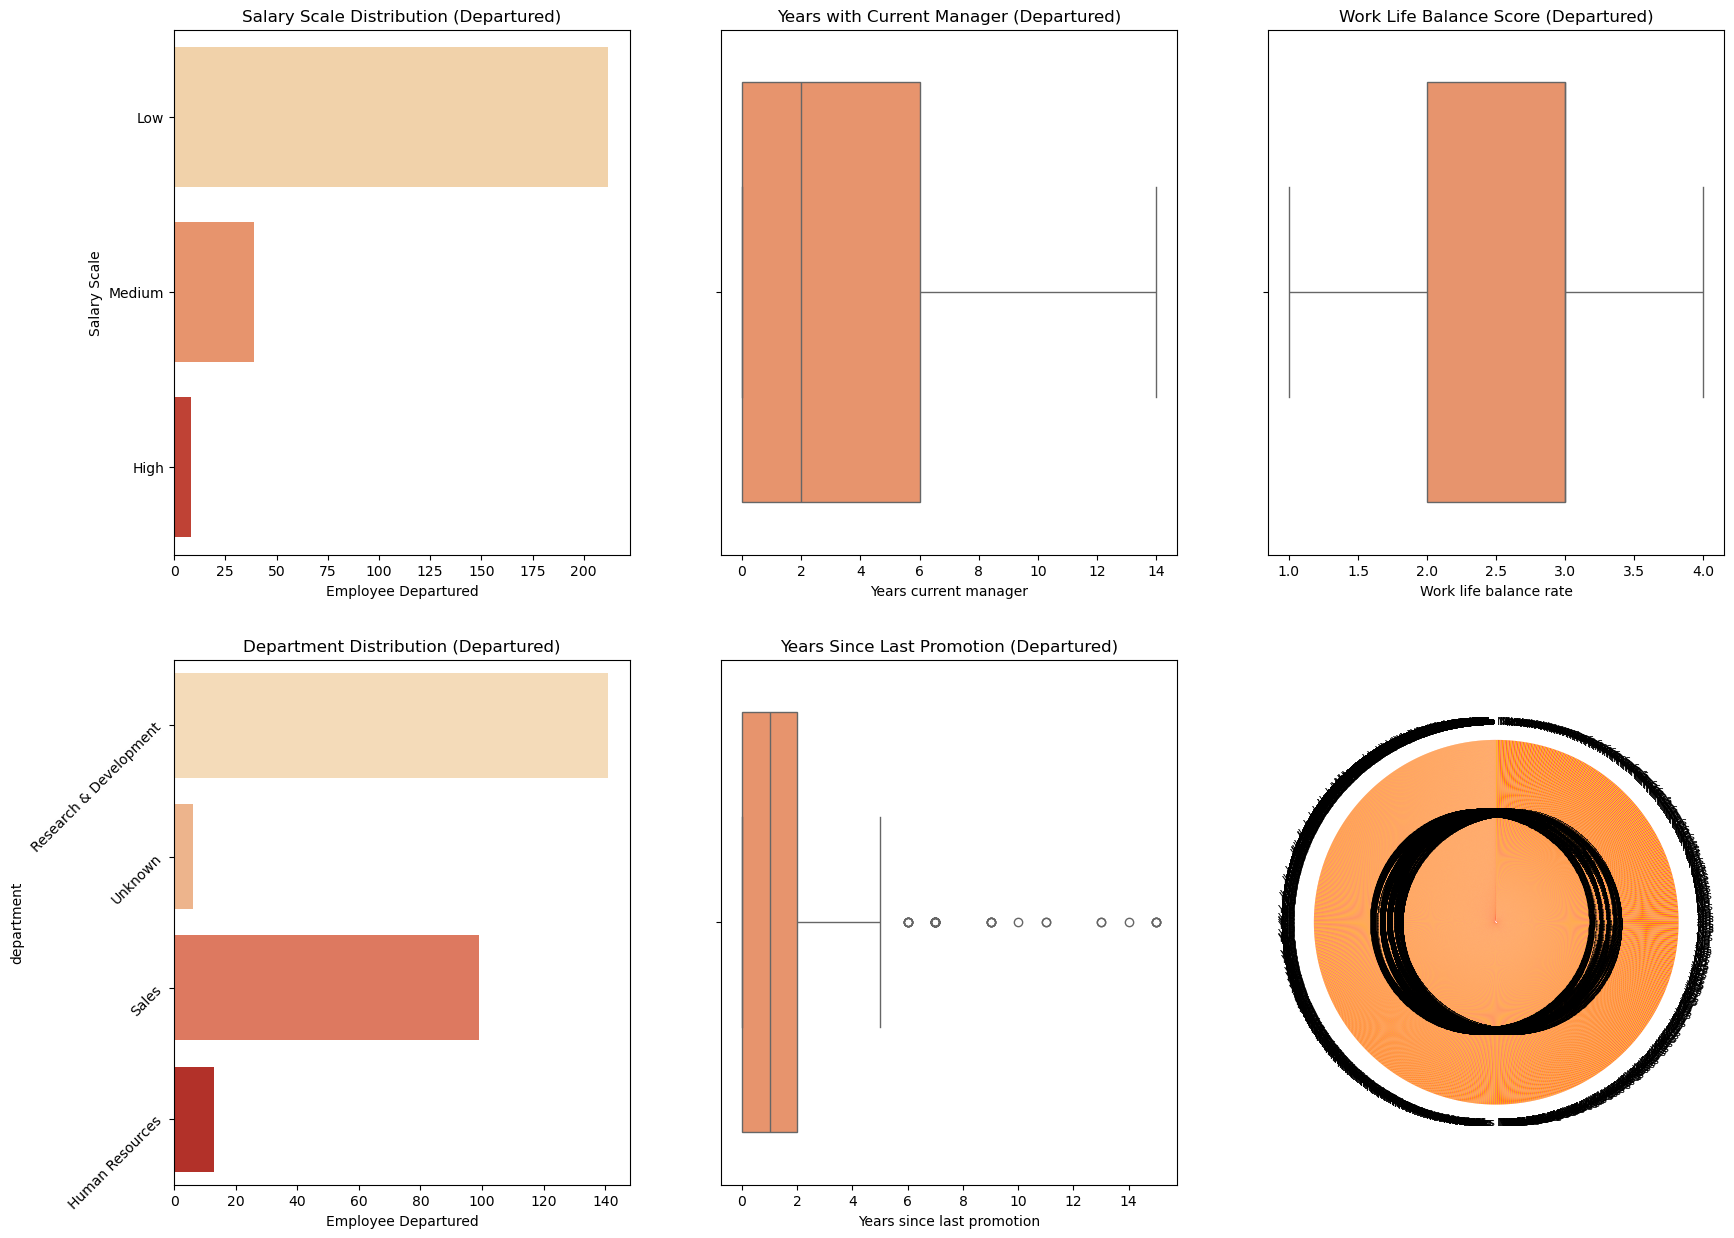

In [43]:
df['current_mngr'] = pd.cut(df['year_current_mngr'],bins = 4, labels= ['0-5', '6-10', '11-15', '16-20'])
yes_df = df[df['departured'] == 'Yes']
fig, axes = plt.subplots(2, 3, figsize=(20, 15))


sns.countplot(data=yes_df,
              y='salary_scale',
              ax=axes[0, 0],
              palette='OrRd')
axes[0, 0].set_title('Salary Scale Distribution (Departured)')
axes[0, 0].set_xlabel('Employee Departured')
axes[0, 0].set_ylabel('Salary Scale')


sns.countplot(data=yes_df,
              y='department',
              ax=axes[1, 0],
              palette='OrRd')
axes[1, 0].set_title('Department Distribution (Departured)')
axes[1, 0].tick_params(axis='y', rotation=45)
axes[1, 0].set_xlabel('Employee Departured')


sns.boxplot(data=yes_df,
            x='year_current_mngr',
            ax=axes[0, 1],
            palette='OrRd')
axes[0, 1].set_title('Years with Current Manager (Departured)')
axes[0, 1].tick_params(axis='y', rotation=45)
axes[0, 1].set_xlabel('Years current manager')
axes[0, 1].set_ylabel('')
axes[0, 1].tick_params(axis='y', rotation=90)


sns.boxplot(data=yes_df, x='year_last_promotion',
            ax=axes[1, 1],
            palette='OrRd')
axes[1, 1].set_title('Years Since Last Promotion (Departured)')
axes[1, 1].tick_params(axis='y', rotation=90)
axes[1, 1].set_ylabel(' ')
axes[1, 1].set_xlabel('Years since last promotion')


sns.boxplot(data=yes_df, x='work_life_balance',
            ax=axes[0, 2],
            palette='OrRd')
axes[0, 2].set_title('Work Life Balance Score (Departured)')
axes[0, 2].set_ylabel('')
axes[0, 2].tick_params(axis='y', rotation=90)
axes[0, 2].set_xlabel('Work life balance rate')


plt.pie('employee_number', labels='departured', data=df, autopct = '%1.2f%%', colors=['tomato', 'orange'], startangle=90, textprops={'fontsize': 8});


#sns.histplot(data=df,
              #x='departured',
              #ax=axes[1, 2],
              #color='tomato')
#axes[1, 2].set_title('Department Distribution (Departured)')
#axes[1, 2].tick_params(axis='y', rotation=45)
#axes[1, 2].set_xlabel('Employee Departured')


In [23]:
# sns.scatterplot(x = "dist_home", 
#                 y = "env_sat_rate", 
#                 data = df, 
#                 size = 5, 
#                 color = "darkred")

# # ponemos los nombres de los ejes
# plt.ylabel("Tasa satisfacción")
# plt.xlabel("distancia trabajo-casa")
# plt.title("Relación entre la satisfacción del trabajador y la distancia trabajo casa", fontsize = 8);

In [24]:
# sns.scatterplot(x = "year_at_comp", 
#                 y = "env_sat_rate", 
#                 data = df, 
#                 size = 5, 
#                 color = "darkred")

# # ponemos los nombres de los ejes
# plt.xlabel("Años en la empresa")
# plt.ylabel("Tasa satisfaccion")
# plt.title("Relación entre la satisfacción del trabajador y los años en la empresa", fontsize = 8);

In [25]:
# sns.scatterplot(x = "year_at_comp", 
#                 y = "year_current_mngr", 
#                 data = df, 
#                 size = 5, 
#                 color = "darkred")

# # ponemos los nombres de los ejes
# plt.xlabel("Años en la empresa")
# plt.ylabel("Años con mismo jefe")
# plt.title("Relación entre los años con el mismo jefe y los años en la empresa", fontsize = 8);